
# time-series-project

1. Install yahoo finance library (yfinance)
2. Retrieve stock price data
3. Choose any ticker symbol and you can choose “Open” or “Close” price for this project<sup>[1](#myfootnote1)</sup> <sup>[2](#myfootnote2)</sup>
4. Analyse time series<sup>[3](#myfootnote3)</sup>
5. Check for seasonality
6. Train time series model
7. Find the best hyperparameter values of (P, D, Q) with the smallest RMSE for building an ARIMA model<sup>[4](#myfootnote4)</sup>
8. Predict price for the next time period (Maybe two Timestamps)
9. Save timestamp, prediction and actual price to a database

❗ BONUS: Deploy your model to Streamlit.  
a. The app should pull fresh data from the web through yfinance  
b. The user should be able to define a forecasting window (how far ahead they want the forecast)  

❗❗ Extra Super Hard BONUS!! Allow the user to choose the ticker symbol to look up and get predictions for.   
HINT: you'll need to refit the model. This may be hard without determining again the P, D, and Q

<a name="myfootnote1">1</a>: The program should only run between 8am and 4pm ET  
<a name="myfootnote2">2</a>: The data period and interval should be 1 year and 1 hour respectively  
<a name="myfootnote3">3</a>: Choose the last 50 records as your test data for the purpose of saving time  
<a name="myfootnote4">4</a>: Please set the hyperparameter values of (P, D, Q) within these ranges also for the purpose of saving time: For “P”: 1 ≦ P ≦ 3 For “D”: 0 ≦ D ≦ 2 For “Q”: 0 ≦ Q ≦ 2


In [79]:
# Base Imports

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats='retina'

plt.style.use("ggplot")

import numpy as np
import pandas as pd

import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", InterpolationWarning)

from sklearn.preprocessing import power_transform
from sklearn import set_config

set_config(transform_output="pandas")


# ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:
# Null Hypothesis: The series has a unit root.
# Alternate Hypothesis: The series has no unit root.
# If the null hypothesis fails to be rejected, this test may provide evidence that the series is non-stationary.
def adf_test(timeseries, autolag="AIC"):
    from statsmodels.tsa.stattools import adfuller

    # "AIC" (Akaike Information Criterion):
    # This option selects the lag length that minimizes the AIC.
    # The AIC is a measure that balances the goodness of fit of a statistical model with its complexity.
    # Lower AIC values generally indicate a better model.
    # "BIC" (Bayesian Information Criterion):
    # Similar to AIC, this option chooses the lag length that minimizes the BIC.
    # The BIC also balances model fit and complexity, but it tends to penalize complex models more heavily than the AIC.
    # "t-stat" (t-statistic):
    # This method starts with the maximum lag length (maxlag) and iteratively reduces it.
    # It stops when the t-statistic of the last lag becomes statistically significant (typically at a 5% significance level).
    # This approach focuses on the statistical significance of the individual lags.
    dftest = adfuller(
        timeseries.dropna(), 
        autolag=autolag, )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput[autolag] = dftest[5]

    dfoutput.name = "Results of Dickey-Fuller Test"

    if (dftest[1] < 0.05) & (dftest[4]["5%"] > dftest[0]):
        print(
            "\u001b[32mConclusion: The data is stationary (Reject the null hypothesis)\u001b[0m"
        )
    else:
        print(
            "\x1b[31mConclusion: The data is not stationary (Fail to reject the null hypothesis)\x1b[0m"
        )
    return dfoutput


# KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
# Null Hypothesis: The process is trend stationary.
# Alternate Hypothesis: The series has a unit root (series is not stationary).
def kpss_test(timeseries, regression="c"):
    from statsmodels.tsa.stattools import kpss

    kpsstest = kpss(timeseries.dropna(), regression=regression, nlags="auto")
    kpssoutput = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpssoutput["Critical Value (%s)" % key] = value

    kpssoutput.name = "Results of KPSS Test"

    if (kpsstest[1] < 0.05) & (kpsstest[3]["5%"] > kpsstest[0]):
        print(
            "\x1b[31mConclusion: The data is not stationary (Reject the null hypothesis)\x1b[0m"
        )

    else:
        print(
            "\u001b[32mConclusion: The data is stationary (Fail to reject the null hypothesis)\u001b[0m"
        )

    return kpssoutput


def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


In [80]:
# Install yahoo finance library (yfinance)
# %conda install yfinance

import yfinance as yf

# # Now you can use yfinance functions
# dat = yf.Ticker("MSFT")
# dat.info
# dat.calendar
# dat.analyst_price_targets
# dat.quarterly_income_stmt
# dat.history(period='1mo')
# dat.option_chain(dat.options[0]).calls

# Choose stock

In [81]:
# Retrieve stock price data
# Choose any ticker symbol and you can choose “Open” or “Close” price for this project

# hoping to build model for
# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'XOM', 'V', 'WMT', 'NVDA', 'PG',
#             'LLY', 'CVX', 'MA', 'HD', 'PFE', 'ABBV', 'MRK', 'KO', 'PEP', 'AVGO', 'ORCL',
#             'TMO', 'AZN', 'CSCO', 'DHR', 'MCD', 'ABT', 'TMUS', 'ACN', 'NEE', 'VZ', 'TTE',
#             'LIN', 'DIS', 'PM', 'BMY', 'CMCSA', 'SCHW', 'UPS', 'TXN', 'RTX', 'COP']
# will start with 'AAPl'


from datetime import datetime

# 1. Define the ticker and date range
tickers = ["AAPL"]
end_date = datetime.today().strftime('%Y-%m-%d')

start_date = (pd.to_datetime(end_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')  # 1 year before

# 2. Download data from yfinance
yf_dl = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    actions=False,
    threads=True,
    ignore_tz=None,
    group_by="column",
    auto_adjust=True,
    back_adjust=False,
    repair=False,
    keepna=False,
    progress=True,
    # period="1y",
    interval="1h",
    prepost=False,
    proxy=None,
    rounding=False,
    timeout=10,
    session=None,
    multi_level_index=False,
)

yf_dl.head(35)

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2024-04-08 13:30:00+00:00,168.820007,169.190002,168.240005,169.059998,8279940
2024-04-08 14:30:00+00:00,168.815002,169.130005,168.649994,168.824997,4718366
2024-04-08 15:30:00+00:00,168.412399,168.815002,168.264999,168.815002,4134102
2024-04-08 16:30:00+00:00,168.645004,168.835007,168.404999,168.414993,2982857
2024-04-08 17:30:00+00:00,168.790100,168.899994,168.470001,168.645004,2336490
2024-04-08 18:30:00+00:00,168.785004,168.799896,168.544998,168.794998,2798561
2024-04-08 19:30:00+00:00,168.460007,168.960007,168.324997,168.785004,4991117
2024-04-09 13:30:00+00:00,169.470001,170.074997,168.500000,168.692001,9892473
2024-04-09 14:30:00+00:00,168.695007,169.490005,168.479996,169.475006,5975622


In [82]:
import holidays
nyse_holidays = holidays.financial_holidays('NYSE')  
type(nyse_holidays)

holidays.financial.ny_stock_exchange.NYSE

In [83]:
# Analyse time series

from pandas.tseries.offsets import Minute, BusinessHour
fifteen_min = Minute(n=15)
thirty_min = Minute(n=30)
fourh_thirtym = Minute(n=270)

import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
holidays = nyse.holidays()
v_days = nyse.valid_days(start_date='2016-12-20', end_date='2017-01-10')


schedule = nyse.schedule(start_date='2016-12-30', end_date='2017-01-10')



# , offset=-fourh_thirtym
# df.resample(rule='168h', origin='2021-04-22 00:00:00', closed='right', label='right').sum()


yf_dl = yf_dl.resample(rule=holidays).last() # resample by business day
yf_dl.index.freq = holidays
yf_dl.head(20)

,Close,High,Low,Open,Volume
Datetime,,,,,
2024-04-08 00:00:00+00:00,168.460007,168.960007,168.324997,168.785004,4991117
2024-04-09 00:00:00+00:00,169.690002,169.729996,168.940002,169.259995,5472554
2024-04-10 00:00:00+00:00,167.750000,168.684998,167.699997,168.259995,5084905
2024-04-11 00:00:00+00:00,175.039993,175.460007,174.619995,174.740005,15008834
2024-04-12 00:00:00+00:00,176.565002,176.740005,175.955002,176.014999,10614487
2024-04-15 00:00:00+00:00,172.684998,173.610001,172.660004,172.929993,6819556
2024-04-16 00:00:00+00:00,169.337906,170.014999,169.279999,169.990005,5938491
2024-04-17 00:00:00+00:00,168.000000,168.544998,168.000000,168.089996,5025607
2024-04-18 00:00:00+00:00,167.039993,167.374298,166.774994,167.100006,4286307


(20080.0, 20090.0)

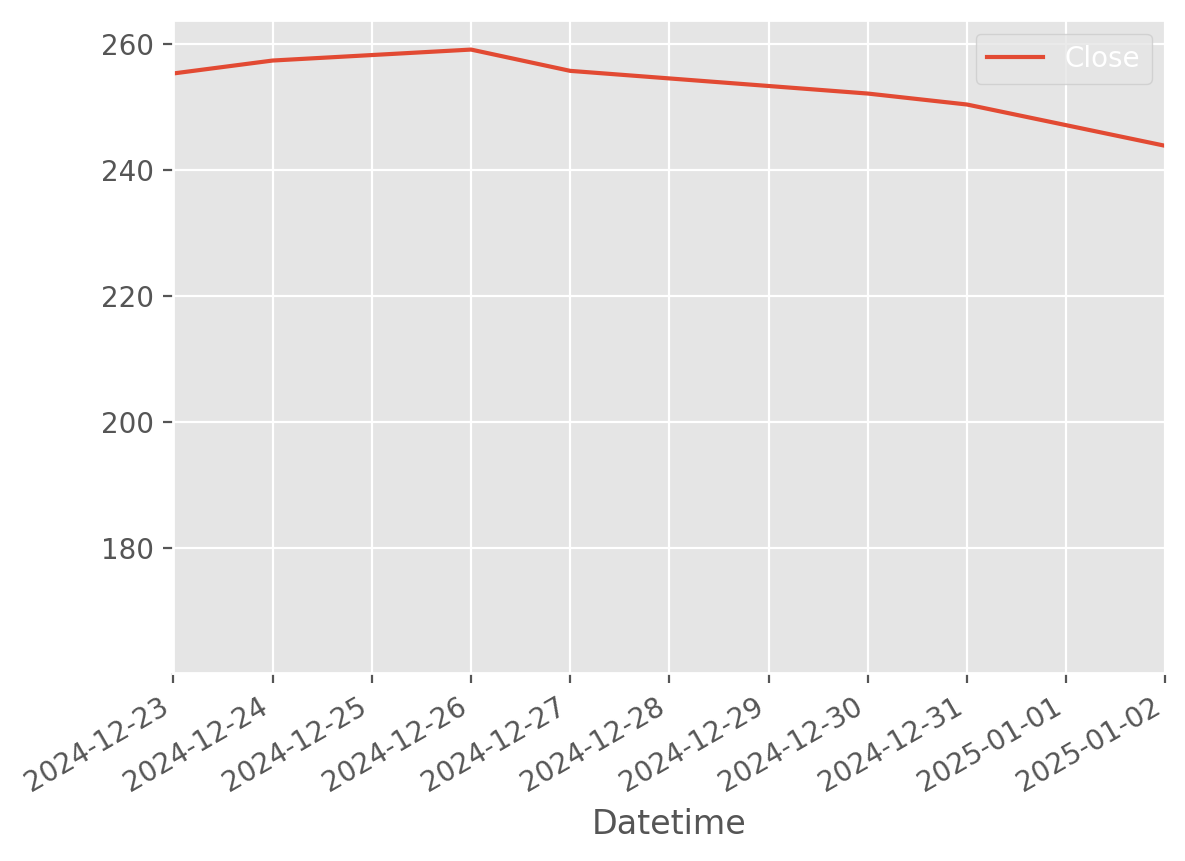

In [84]:
yf_dl.plot(y="Close")
plt.xlim("2024-12-23 00:00:00+00:00", "2025-01-02 00:00:00+00:00")

In [85]:
timeseries = yf_dl["Close"]
timeseries

Datetime
2024-04-08 00:00:00+00:00    168.460007
2024-04-09 00:00:00+00:00    169.690002
2024-04-10 00:00:00+00:00    167.750000
2024-04-11 00:00:00+00:00    175.039993
2024-04-12 00:00:00+00:00    176.565002
                                ...    
2025-03-31 00:00:00+00:00    221.994995
2025-04-01 00:00:00+00:00    223.139999
2025-04-02 00:00:00+00:00    223.789993
2025-04-03 00:00:00+00:00    203.470001
2025-04-04 00:00:00+00:00    188.380005
Freq: C, Name: Close, Length: 250, dtype: float64

In [86]:
from scipy.signal import periodogram, find_peaks

# Compute power spectrum
frequencies, power = periodogram(timeseries.dropna())
# Find peaks in the power spectrum
peaks, _ = find_peaks(power, height=0.1 * max(power))  # Tune height threshold
# Convert frequency to period
periods = 1 / frequencies[peaks]

periods

array([250.])

In [87]:
adf_test(timeseries).round(6)

Conclusion: The data is not stationary (Fail to reject the null hypothesis)


Test Statistic                   -2.079612
p-value                           0.252791
#Lags Used                        1.000000
Number of Observations Used     248.000000
Critical Value (1%)              -3.456996
Critical Value (5%)              -2.873266
Critical Value (10%)             -2.573019
AIC                            1278.365219
Name: Results of Dickey-Fuller Test, dtype: float64

In [88]:
kpss_test(timeseries)

Conclusion: The data is stationary (Fail to reject the null hypothesis)


Test Statistic            1.465002
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Name: Results of KPSS Test, dtype: float64

In [89]:
adf_lags_used = adf_test(timeseries).iloc[2] # lags used by ADF test
adf_lags_used += 1 # need to add lag 0 to complete the period
period = adf_lags_used.astype(int) # convert to int

if period < 10:
    period = 10
else:
    period = period

Conclusion: The data is not stationary (Fail to reject the null hypothesis)


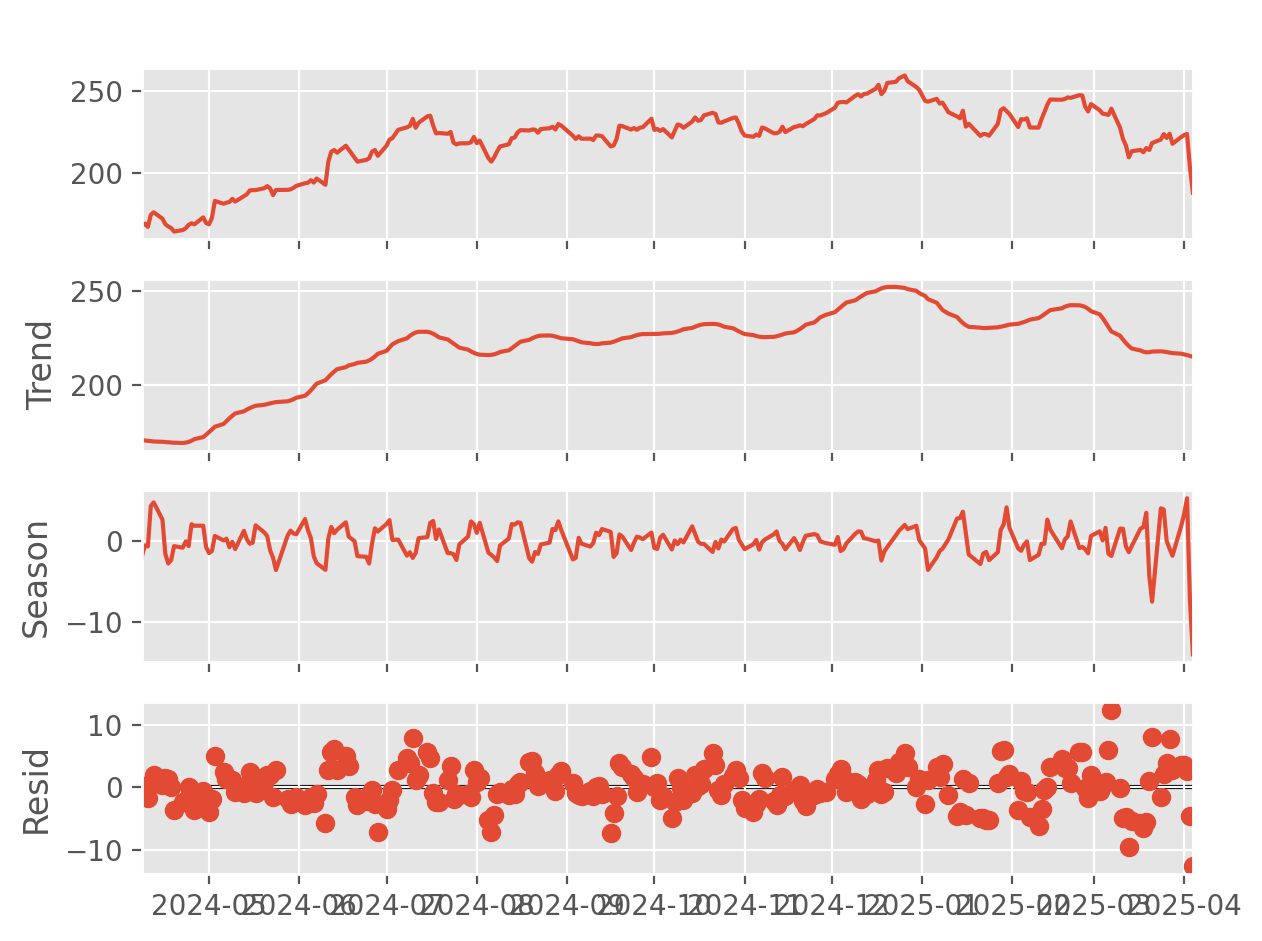

<Figure size 640x480 with 0 Axes>

In [90]:
from statsmodels.tsa.seasonal import STL

seasonal = period + ((period % 2) == 0)  # Ensure odd
seasonal_jump = int(np.ceil(0.15 * (period + 1)))
low_pass_jump = int(np.ceil(0.15 * (period + 1))) # must be a positive integer
trend_jump = int(np.ceil(0.15 * 1.5 * (period + 1)))

if low_pass_jump < 1:
    low_pass_jump = 1
else:
    low_pass_jump = low_pass_jump

if seasonal_jump < 1:
    seasonal_jump = 1
else:
    seasonal_jump = seasonal_jump



mod = STL(
    timeseries,
    period=period,
    seasonal=seasonal,
    seasonal_deg=1, 
    trend_deg=1, 
    low_pass_deg=1, 
    robust=True,
    seasonal_jump=seasonal_jump,
    trend_jump=trend_jump,
    low_pass_jump=low_pass_jump,
)

res = STL(timeseries, period=period).fit()
res.plot()
plt.show()
plt.tight_layout();

In [91]:
mod_seasonal = res.seasonal

In [92]:
mod.config

{'period': 10,
 'seasonal': 11,
 'seasonal_deg': 1,
 'seasonal_jump': 2,
 'trend': 19,
 'trend_deg': 1,
 'trend_jump': 3,
 'low_pass': 11,
 'low_pass_deg': 1,
 'low_pass_jump': 2,
 'robust': True}

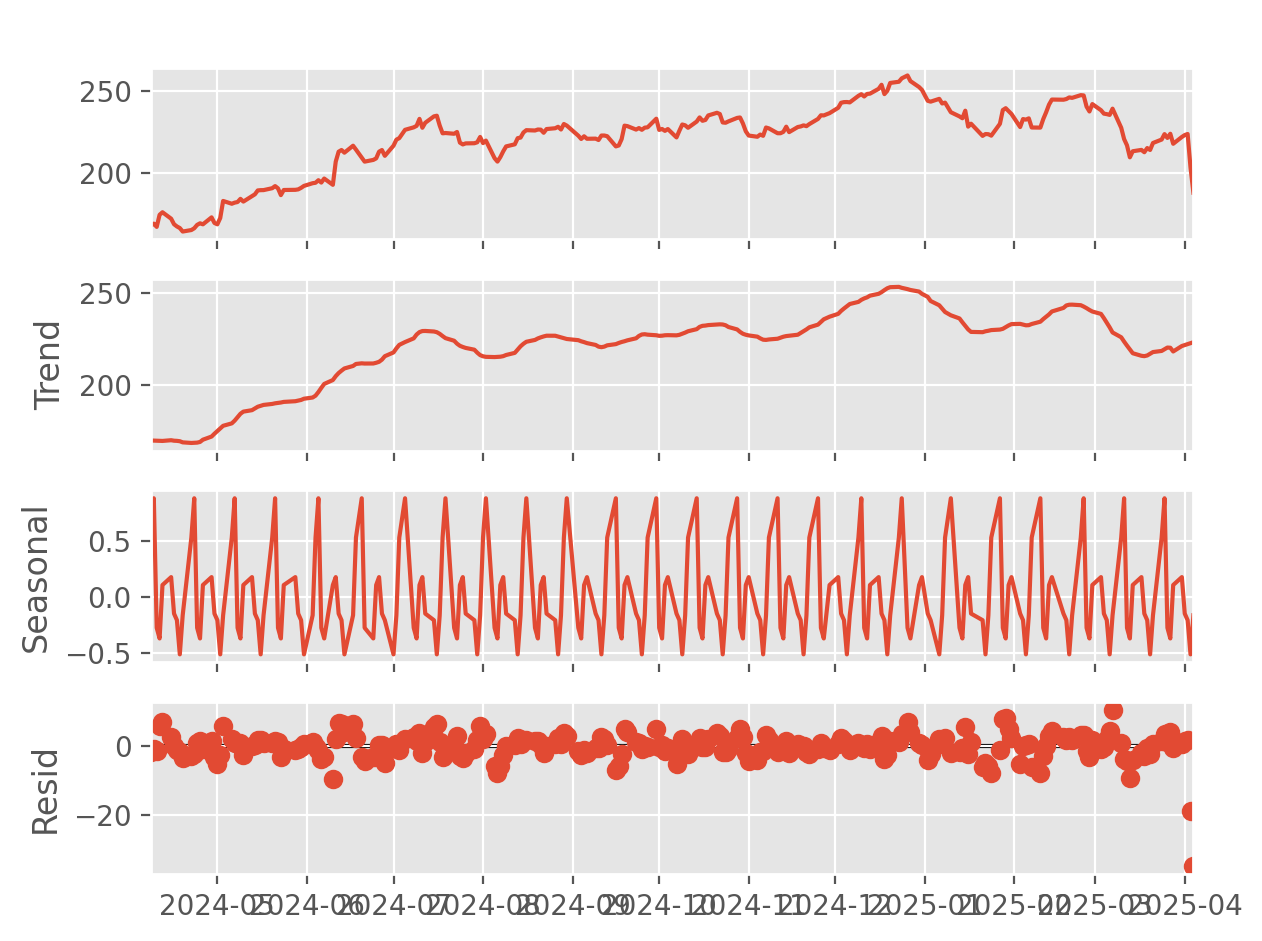

In [ ]:
# Import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Check for seasonality
decomposition = seasonal_decompose(
    timeseries.dropna(), 
    model="additive", 
    filt=None, 
    period=period, 
    two_sided=True, 
    extrapolate_trend="freq"
)
decomposition.plot()
plt.fi
plt.tight_layout();

<Axes: xlabel='Datetime'>

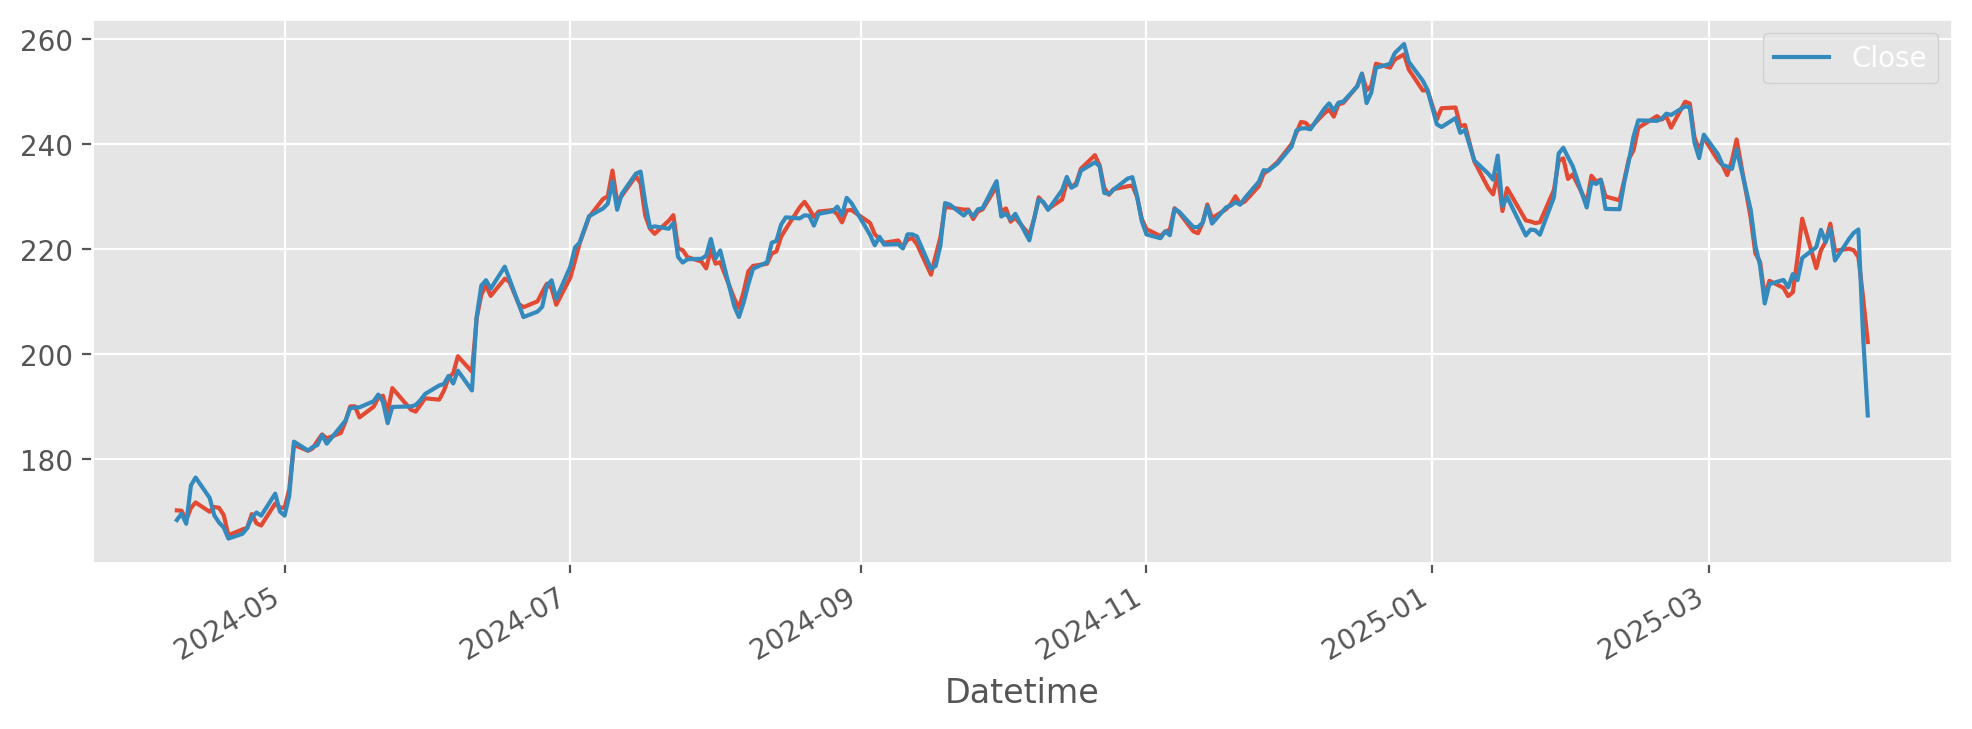

In [94]:

seasonals = decomposition.seasonal
trends = decomposition.trend

no_seasons = timeseries - mod_seasonal 

timeseries_cleaned = no_seasons

# timeseries_cleaned = trends

fig, ax = plt.subplots(figsize=(12, 4))
timeseries_cleaned.plot(y="Close", ax=ax)
yf_dl.plot(y="Close", ax=ax)
# trends.plot()
# yf_dl.plot(y="Close_no_seasonal_trend")
# decomposition


In [95]:
adf_test(timeseries=timeseries_cleaned).round(6)

Conclusion: The data is not stationary (Fail to reject the null hypothesis)


Test Statistic                   -2.729513
p-value                           0.069069
#Lags Used                       16.000000
Number of Observations Used     233.000000
Critical Value (1%)              -3.458731
Critical Value (5%)              -2.874026
Critical Value (10%)             -2.573424
AIC                            1186.363987
Name: Results of Dickey-Fuller Test, dtype: float64

In [96]:
kpss_test(timeseries=timeseries_cleaned)

Conclusion: The data is stationary (Fail to reject the null hypothesis)


Test Statistic            1.476601
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Name: Results of KPSS Test, dtype: float64

In [97]:
# Train/test split for time series model training

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    timeseries_cleaned, 
    test_size=period, 
    shuffle=False
)
display(train.tail(period))
print(train.shape)
display(test.head(period))
print(test.shape)


Datetime
2025-03-10 00:00:00+00:00    226.023821
2025-03-11 00:00:00+00:00    219.233737
2025-03-12 00:00:00+00:00    217.615148
2025-03-13 00:00:00+00:00    211.104704
2025-03-14 00:00:00+00:00    214.022332
2025-03-17 00:00:00+00:00    212.679292
2025-03-18 00:00:00+00:00    211.097610
2025-03-19 00:00:00+00:00    211.830502
2025-03-20 00:00:00+00:00    218.373713
2025-03-21 00:00:00+00:00    225.846952
Freq: C, dtype: float64

(240,)


Datetime
2025-03-24 00:00:00+00:00    216.417060
2025-03-25 00:00:00+00:00    219.849266
2025-03-26 00:00:00+00:00    221.421820
2025-03-27 00:00:00+00:00    224.891938
2025-03-28 00:00:00+00:00    219.709591
2025-03-31 00:00:00+00:00    220.134653
2025-04-01 00:00:00+00:00    219.831192
2025-04-02 00:00:00+00:00    218.533434
2025-04-03 00:00:00+00:00    210.814666
2025-04-04 00:00:00+00:00    202.365848
Freq: C, dtype: float64

(10,)


In [98]:
from statsmodels.tsa.stattools import acf, pacf


pacf_values = pacf(
    train, 
    nlags=None, 
    method="burg"
    )

acf_values = acf(
    train,
    adjusted=False, 
    nlags=None,
    qstat=False,
    fft=True,
    bartlett_confint=True,
    missing="none",
)

alpha = 0.05 # set our confidence at 5%
# iterate to set p and q as we would graphically
p = -1
for val in pacf_values:
    if np.abs(val) > alpha:
        p += 1
    else:
        break
if p > 0:
    p = p
else:
    p = 0

q = -1
for val in acf_values:
    if np.abs(val) > alpha:
        q += 1
    else:
        break
if q > 0:
    q = q
else:
    q = 0

In [99]:
# Find the best hyperparameter values of (P, D, Q) with the smallest RMSE for building an ARIMA model
# Please set the hyperparameter values of (P, D, Q) within these ranges also for the purpose of saving time:
# For “P”: 1 ≦ P ≦ 3 For “D”: 0 ≦ D ≦ 2 For “Q”: 0 ≦ Q ≦ 2

from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

model_0 = ARIMA(
    train,
    exog=None,
    order=(p, 0, q),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=True,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing="none",
    validate_specification=True,
)

model_1 = ARIMA(
    train,
    exog=None,
    order=(p, 1, q),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=True,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing="none",
    validate_specification=True,
)

model_2 = ARIMA(
    train,
    exog=None,
    order=(p, 2, q),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=True,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing="none",
    validate_specification=True,
)

fitted_model_0 = model_0.fit()
fitted_model_1 = model_1.fit()
fitted_model_2 = model_2.fit()

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaco

In [100]:
# Predict price for the next time period (Maybe two Timestamps)
stock_forecast_0 = fitted_model_0.forecast(steps=len(test))
stock_forecast_1 = fitted_model_1.forecast(steps=len(test))
stock_forecast_2 = fitted_model_2.forecast(steps=len(test))

# test_results = pd.DataFrame(columns=["test", "test_forecast"])
# test_results["test"] = test
# test_results["test_forecast"] = stock_forecast

# Generate forecasts for the test period
# stock_forecast = fitted_model.forecast(steps=len(test))

# Create DataFrame with test and forecast values
test_results = pd.DataFrame(
    {"test": test, 
    "test_forecast_0": stock_forecast_0.iloc[0],
    "test_forecast_1": stock_forecast_1.iloc[0],
    "test_forecast_2": stock_forecast_2.iloc[0]
    }, index=test.index
)

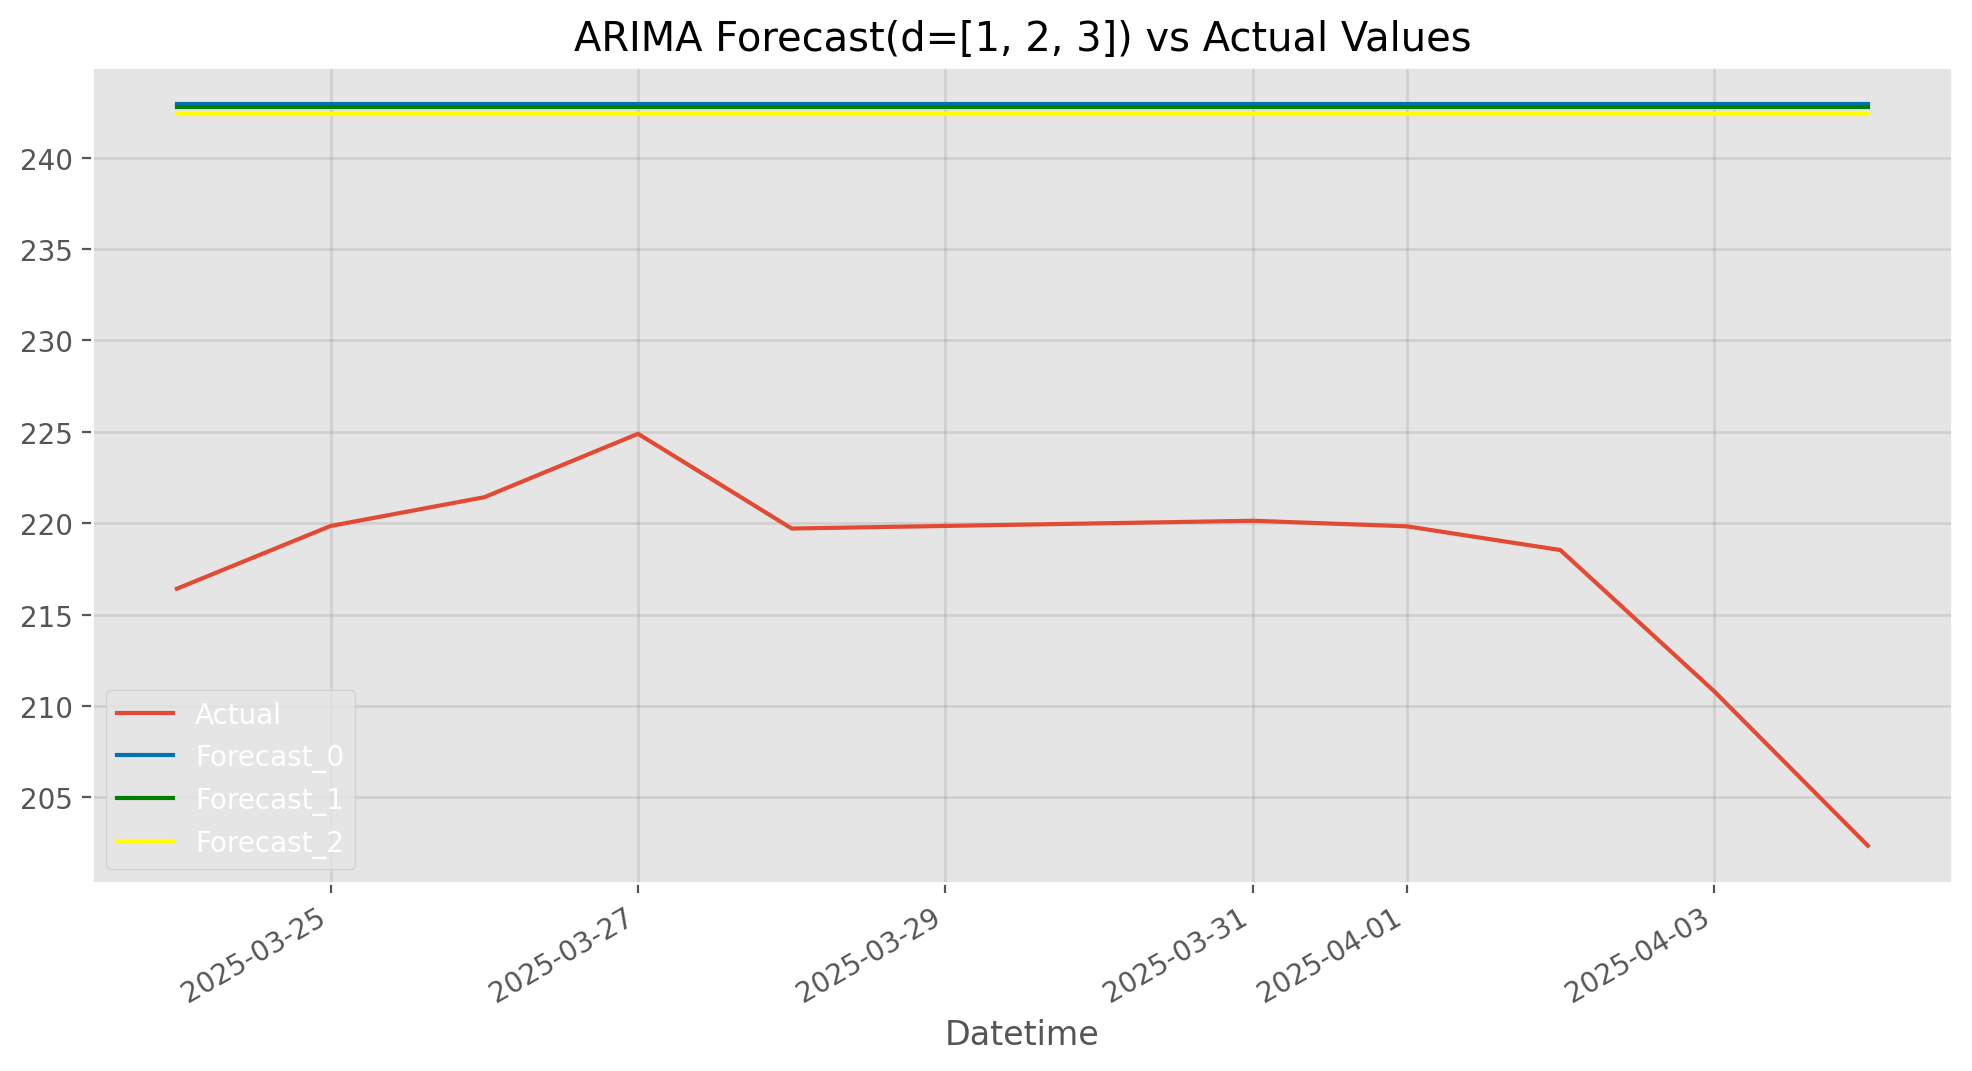

In [101]:
# Plot actual vs predicted values
fig, ax = plt.subplots(figsize=(12, 6))
test_results["test"].plot(label="Actual", ax=ax)
test_results["test_forecast_0"].plot(label="Forecast_0", ax=ax, color="#0072B2")
test_results["test_forecast_1"].plot(label="Forecast_1", ax=ax, color="green")
test_results["test_forecast_2"].plot(label="Forecast_2", ax=ax, color="yellow")

plt.title("ARIMA Forecast(d=[1, 2, 3]) vs Actual Values", color="black")
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.legend()
plt.show()

# test_results.plot();

In [102]:
from pmdarima.arima import auto_arima

automatic = auto_arima(
    test,
    X=None,
    start_p=2,
    d=None,
    start_q=2,
    max_p=p+2,
    max_d=4,
    max_q=q+2,
    start_P=1,
    D=None,
    start_Q=1,
    max_P=2,
    max_D=1,
    max_Q=2,
    max_order=5,
    m=1,
    seasonal=True,
    stationary=False,
    information_criterion="aic",
    alpha=0.05,
    test="adf",
    seasonal_test="STL",
    stepwise=True,
    n_jobs=1,
    start_params=None,
    trend=None,
    method="lbfgs",
    maxiter=100,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action="trace",
    trace=False,
    random=False,
    random_state=None,
    n_fits=100,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring="mse",
    scoring_args=None,
    with_intercept="auto",
    sarimax_kwargs=None)

automatic.fit(train)


/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ARIMA(maxiter=100, order=(1, 4, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

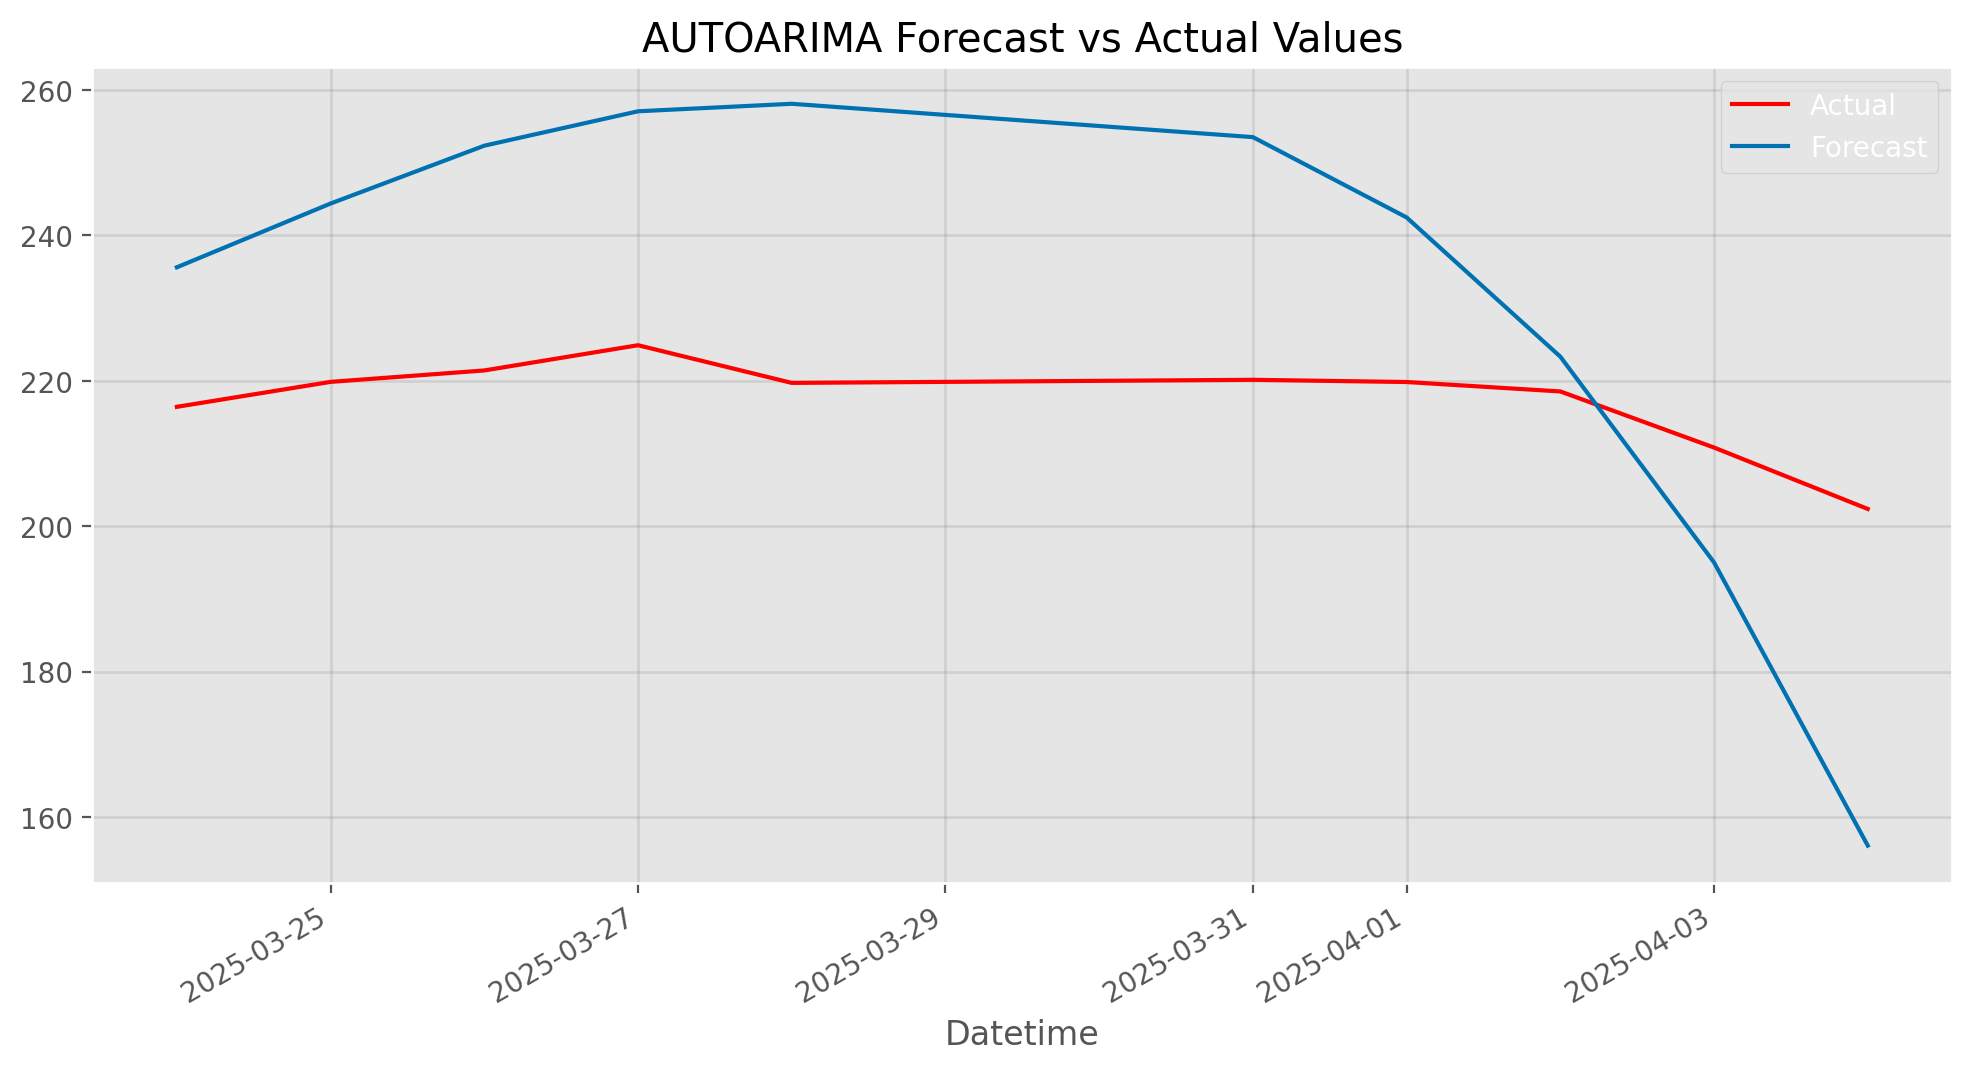

In [103]:
auto_forecast = automatic.predict(y=test, n_periods=len(test))
auto_forecast.index = test.index
auto_test_results = pd.DataFrame(
    {"test": test, 
    "forecast": auto_forecast}, index=test.index
)

# Plot actual vs predicted values
# fig, ax = plt.subplots(figsize=(12, 6))
fig = plt.figure(facecolor='w', figsize=(12, 6))
ax = fig.add_subplot(111)

auto_test_results["test"].plot(label="Actual", color="red", ax=ax)
auto_test_results["forecast"].plot(label="Forecast", ax=ax, color="#0072B2", ls='-')

plt.title("AUTOARIMA Forecast vs Actual Values", color="black")
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.legend()
plt.show();

In [104]:
# %conda install pandas_market_calendars
import pandas_market_calendars as mcal

# Create NYSE Holiday calendar
nyse = mcal.get_calendar('NYSE')
nyse_holidays = nyse.holidays()

df_holidays = pd.DataFrame({
    'ds': nyse_holidays.holidays,
    'holiday': nyse_holidays.name
})

10:38:27 - cmdstanpy - INFO - Chain [1] start processing
10:38:27 - cmdstanpy - INFO - Chain [1] done processing


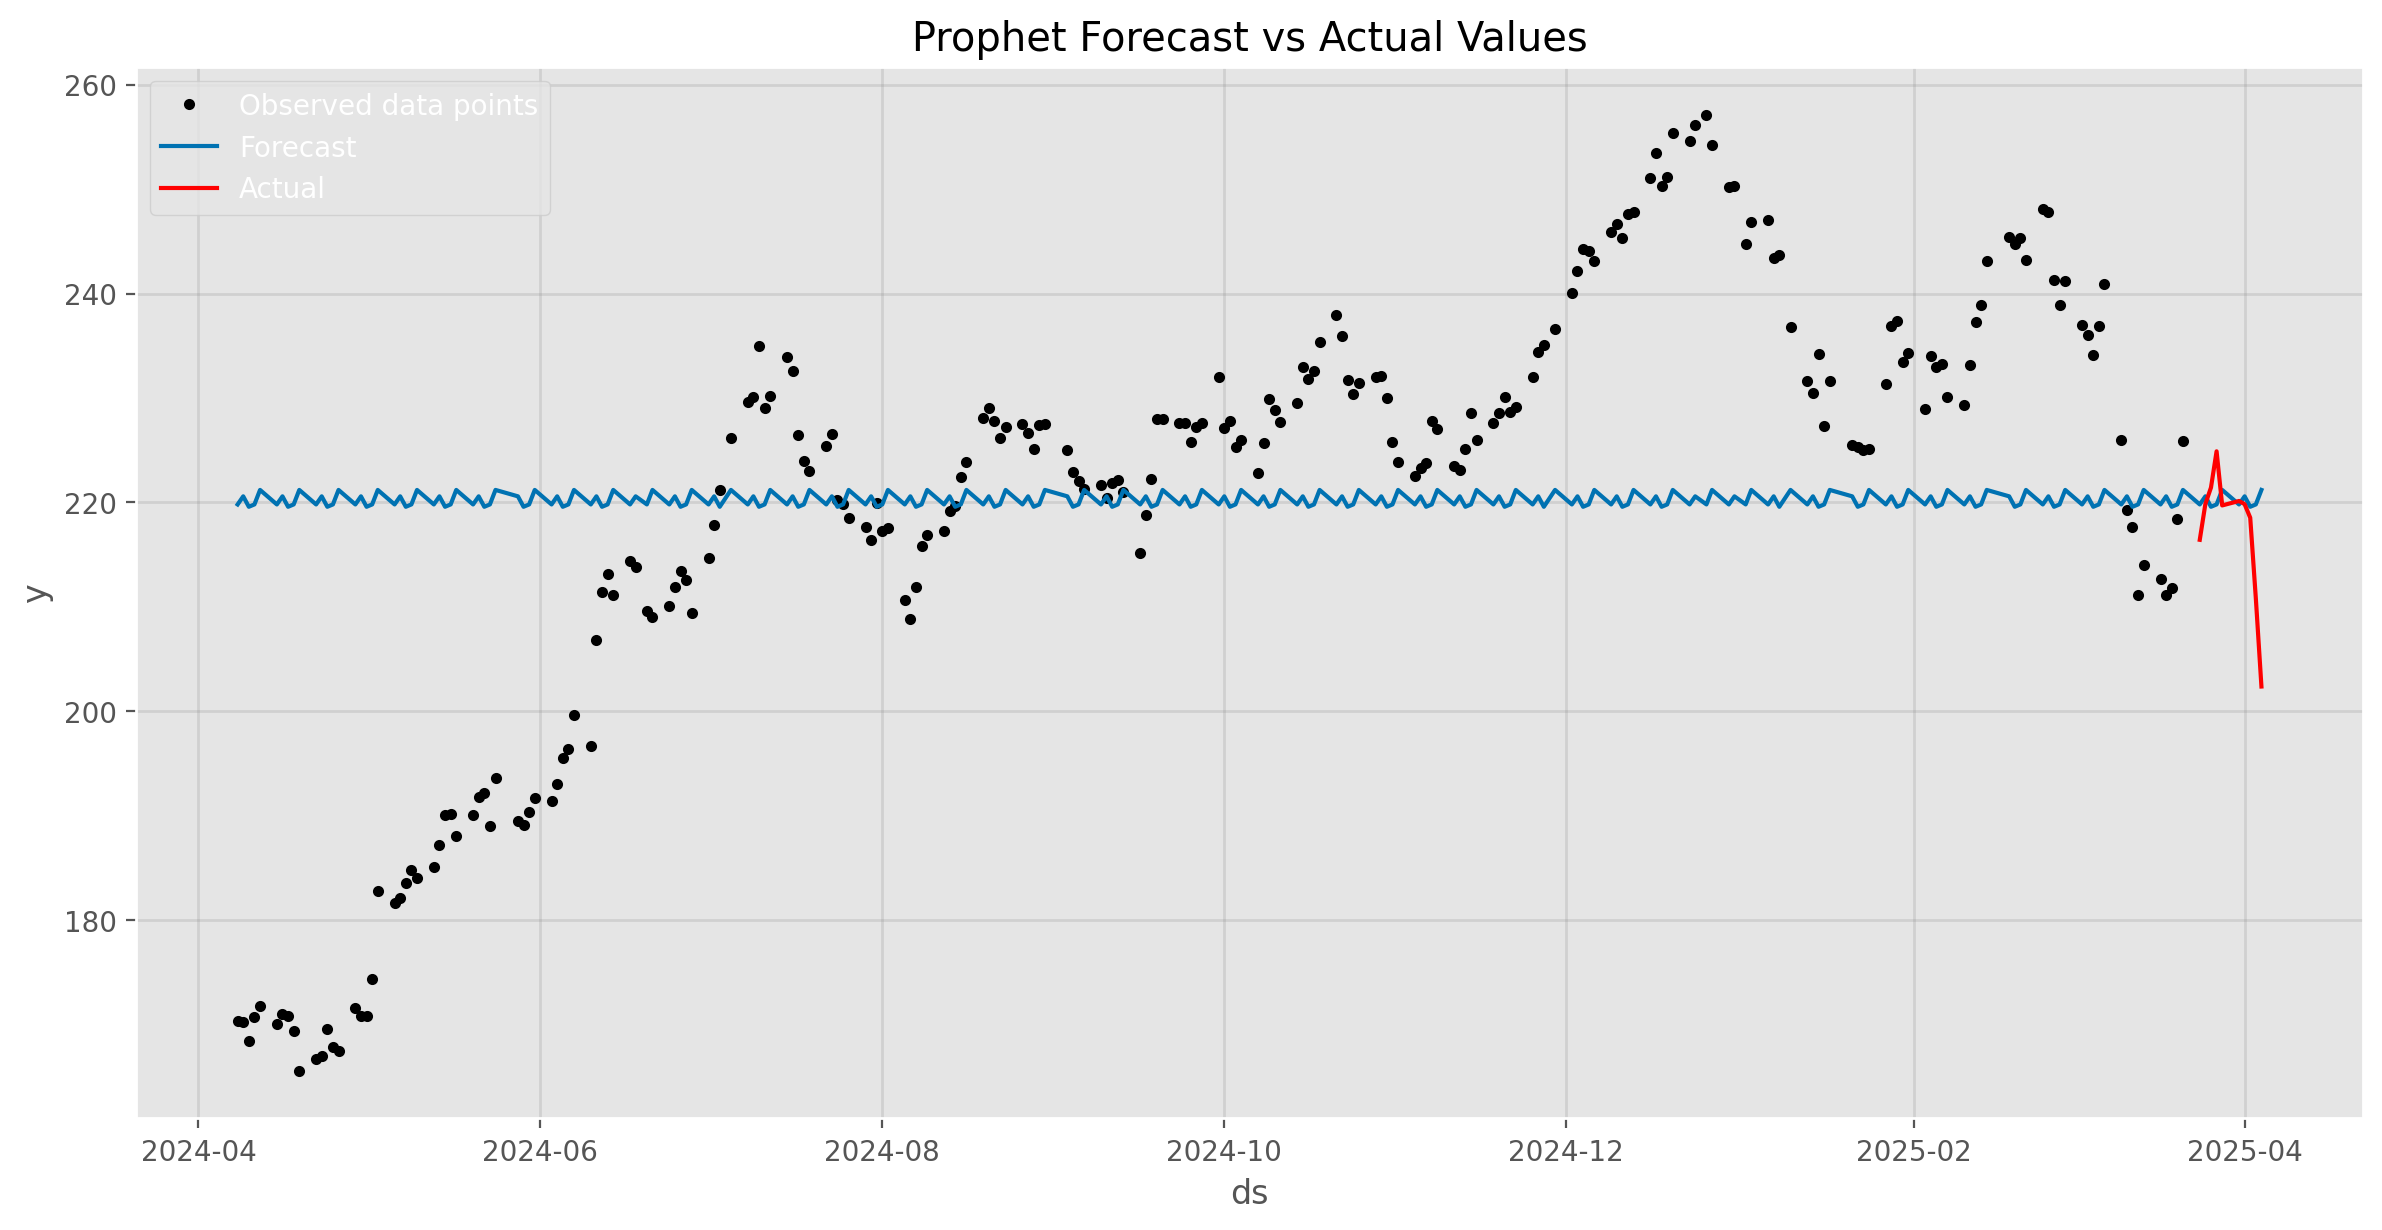

In [105]:
from prophet import Prophet


# Initialize and fit Prophet model
m = Prophet(growth='flat',
            changepoints=None,
            n_changepoints=period, 
            changepoint_range=0.8,
            yearly_seasonality='auto',
            weekly_seasonality='auto',
            daily_seasonality='auto',
            holidays=df_holidays,
            seasonality_mode='additive',
            seasonality_prior_scale=10.0,
            holidays_prior_scale=10.0,
            changepoint_prior_scale=0.05,
            mcmc_samples=0,
            interval_width=0.80,
            uncertainty_samples=1000,
            stan_backend=None,
            scaling='absmax',
            holidays_mode=None,)
# Prepare training data for Prophet
prophet_train = train.reset_index()
prophet_train.columns = ["ds", "y"]

# Remove timezone information from the 'ds' column
prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)

# Fit model on training data
m.fit(prophet_train)

# Create future dataframe with test dates
future = m.make_future_dataframe(periods=period, freq=holidays)

# Make prediction
forecast = m.predict(future)

# Plot results
m.plot(forecast, uncertainty=False, figsize=(12,6))
# plt.xlim(test.index[0], test.index[-1])
# plt.ylim(min(.99*min(test), min(forecast.yhat)), 1.01*max(max(test), max(forecast.yhat)))
plt.title("Prophet Forecast vs Actual Values", color="black")
plt.plot(test, label="Actual", color="red")
plt.legend(loc="best");


# Results

In [106]:
print("The d = 0 root mean squared error is: ", root_mean_squared_error(test_results["test"], test_results["test_forecast_0"]))
print("The d = 1 root mean squared error is: ", root_mean_squared_error(test_results["test"], test_results["test_forecast_1"]))
print("The d = 2 root mean squared error is: ", root_mean_squared_error(test_results["test"], test_results["test_forecast_2"]))
print("The auto ARIMA root mean squared error is: ", root_mean_squared_error(auto_test_results["test"], auto_test_results["forecast"]))
print("The Prophet root mean squared error is: ", root_mean_squared_error(test_results["test"], forecast.yhat[-len(test):]))
print(f"The max p is {p+1}")
print(f"The max q is {q+1}")

The d = 0 root mean squared error is:  26.25739723001916
The d = 1 root mean squared error is:  26.10760495131363
The d = 2 root mean squared error is:  25.702023672859962
The auto ARIMA root mean squared error is:  29.126160166872832
The Prophet root mean squared error is:  6.9323497290379965
The max p is 3
The max q is 24


The sums root mean squared error is:  14.574315042304315


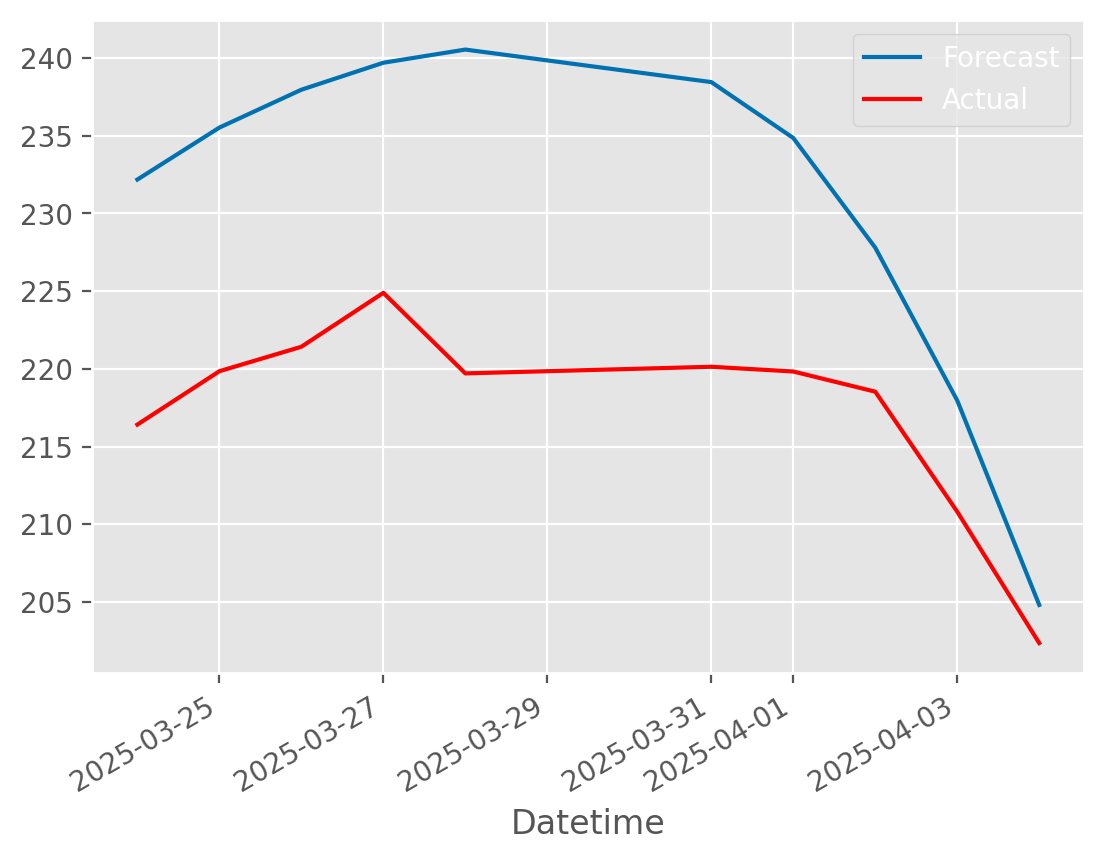

In [107]:
# Save timestamp, prediction and actual price to a database
sumses = []

for _ in range(len(test)):
    sumses.append(
        (.05*test_results["test_forecast_0"][_]
        + .10*test_results["test_forecast_1"][_]
        + .15*test_results["test_forecast_2"][_]
        + .35*auto_test_results["forecast"][_]
        + .35*forecast.yhat[len(forecast.yhat) + _ - len(test)])
    )
    
sumies = pd.DataFrame({"Forecast": sumses}, index=test.index)

print("The sums root mean squared error is: ", root_mean_squared_error(test_results["test"], sumies["Forecast"]))

sumies.plot(label="Forecast", color="#0072B2")
test_results["test"].plot(label="Actual", color="red")
plt.legend();